In [1]:
from bayes_opt import BayesianOptimization
from bayes_opt.observer import JSONLogger
from bayes_opt.event import Events
from bayes_opt.util import load_logs

In [2]:
import numpy as np
import sys
import json
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.backends.backend_pdf import PdfPages


In [3]:
sys.path.insert(0, "../python")
import BayesianOptimizationCustom as bo

In [4]:
optimizer_custum = bo.BayesianOptimizationCustom('../config/params_type.json', 
                                                 '../config/params_init_probe.json', 
                                                 None,
                                                 'output',
                                                 'output', 
                                                 10, 
                                                 '../config/params_type.json',
                                                 1)
params_range = optimizer_custum.ParamsRange()
params_range

{'num_den_layers_pre': (0, 5),
 'num_units_den_layers_pre': (1, 60),
 'num_den_layers_post': (0, 20),
 'num_units_den_layers_post': (1, 60),
 'num_rnn_layers': (1, 10),
 'num_units_rnn_layer': (1, 200),
 'learning_rate_exp': (-4, -2)}

In [50]:
optimizer = BayesianOptimization(
    f=None,
    pbounds=params_range,
    random_state=1, verbose=1
)
# New optimizer is loaded with previously seen points
load_logs(optimizer, logs=["04_12_2019_v18_opt.json"])

In [6]:
optimizer._gp.fit(optimizer._space.params, optimizer._space.target)

GaussianProcessRegressor(alpha=1e-06, copy_X_train=True,
                         kernel=Matern(length_scale=1, nu=2.5),
                         n_restarts_optimizer=25, normalize_y=True,
                         optimizer='fmin_l_bfgs_b',
                         random_state=RandomState(MT19937) at 0x7FED7C4FE150)

In [146]:
optimizer._space.params.shape

(23, 7)

In [7]:
optimizer._space.params.shape

(23, 7)

In [8]:
optimizer._space.keys

['learning_rate_exp',
 'num_den_layers_post',
 'num_den_layers_pre',
 'num_rnn_layers',
 'num_units_den_layers_post',
 'num_units_den_layers_pre',
 'num_units_rnn_layer']

In [69]:
# params = {'activation_dense_post' : 0, 'activation_dense_pre': 1, 'dropout_rate_den_layers_post' : 2,
#           'dropout_rate_den_layers_pre' : 3, 'dropout_rate_rnn': 4, 'learning_rate_exp': 5, 'num_den_layers_post': 6, 
#           'num_den_layers_pre': 7, 'num_rnn_layers': 8, 'num_units_den_layers_post': 9, 
#           'num_units_den_layers_pre': 10, 'num_units_rnn_layer': 11, 'optimizers': 12, 
#           'rnn_type': 13}

params = {'learning_rate_exp' : 0,
          'num_den_layers_post' : 1,
          'num_den_layers_pre': 2,
          'num_rnn_layers': 3,
          'num_units_den_layers_post': 4,
          'num_units_den_layers_pre': 5,
          'num_units_rnn_layer' : 6
         } 

In [52]:
params_pos = {}
for pos in range(len(optimizer._space.target)):
    params_pos[optimizer._space.target[pos]] = pos

In [53]:
order_targets = optimizer._space.target
order_targets = -np.sort(-order_targets)
best_10_order_targets = order_targets[:10]
print(best_10_order_targets)

[0.9517079  0.9493503  0.94924182 0.9491477  0.94913179 0.94871384
 0.94839644 0.94822896 0.94726074 0.94717777]


In [54]:
optimizer._space.target.argmax()

2

In [55]:
best_params = []
for point in best_10_order_targets:
    print(params_pos[point])
    best_params.append(optimizer._space.params[params_pos[point]])
#     max_point

2
0
14
12
19
11
9
16
8
4


In [56]:
# optimizer._space.params[1]

In [57]:
params_score = {}
params = []
for n in range(10):
    params_score[n] = best_params[n]

In [58]:
params_score

{0: array([-3., 10.,  0.,  5., 15., 15., 74.]),
 1: array([-3.,  0.,  0.,  5., 15., 15., 74.]),
 2: array([ -3.47403701,  19.87821588,   0.94085207,   3.31418635,
          1.38870681,  38.16171059, 191.6758524 ]),
 3: array([-3.72962319, 18.93472522,  3.7943582 ,  7.88365782,  1.62497799,
        59.07140529, 88.24788695]),
 4: array([-3.68053713, 19.21262523,  0.51160202,  8.8177722 , 57.98865748,
        42.63674854, 18.92745967]),
 5: array([-3., 20.,  0.,  5., 15.,  1., 74.]),
 6: array([-3.,  5.,  2.,  3., 30., 30., 75.]),
 7: array([ -3.69740384,  19.16075174,   0.63268961,   7.23573859,
         58.01250452,  59.21386083, 198.04732934]),
 8: array([-3.,  5.,  0.,  5., 30., 15., 75.]),
 9: array([-3.,  0.,  0., 10., 15., 15., 74.])}

In [59]:
# with open('10_best_params', 'w') as f:
#         f.write(json.dumps(best_params, indent=4))

In [60]:
max_point = optimizer._space.params[optimizer._space.target.argmax()]
max_point

array([-3., 10.,  0.,  5., 15., 15., 74.])

In [61]:
best_params[n].shape[0]

7

In [143]:
def CreatePlots(max_point, var, pdf, n_bin, plot_title):
    var_points = np.linspace(params_range[var][0], params_range[var][1], 1000)#np.array([0, 1, 2, 3, 4, 5])
    x = np.zeros((var_points.shape[0], max_point.shape[0]))
    for n in range(x.shape[0]):
        x[n, :] = max_point[:]
        x[n, params[var]] = var_points[n]
    print(x[:,0])
    mu, sigma = optimizer._gp.predict(x, return_std=True)
    print('mu:', mu)
#     print('sigma:', sigma)
#     print('2 * sigma:', 2 * sigma)
    fig = plt.figure(figsize=(7, 6))
    ax = plt.gca()
    ax.plot(var_points, mu, '--', color='k', label='Prediction')
    ax.fill(np.concatenate([var_points, var_points[::-1]]), 
        np.concatenate([mu - 2 * sigma, (mu + 2 * sigma)[::-1]]),
        alpha=.6, fc='c', ec='None', label='95% confidence interval', color='yellow')
    ax.fill(np.concatenate([var_points, var_points[::-1]]), 
        np.concatenate([mu - 1 * sigma, (mu + 1 * sigma)[::-1]]),
        alpha=.6, fc='c', ec='None', label='68% confidence interval', color='green')
    ax.set_ylabel('Purity')
    ax.set_xlabel(plot_title)
    plt.title(plot_title)
    ax.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)
    plt.draw()
    plt.show()
    pdf.savefig(fig, bbox_inches='tight')
    plt.close()


[-3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3.
 -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3.
 -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3.
 -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3.
 -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3.
 -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3.
 -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3.
 -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3.
 -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3.
 -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3.
 -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3.
 -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3.
 -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3.
 -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3

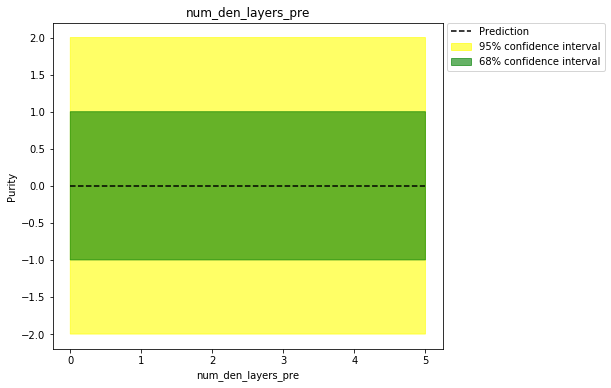

[-3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3.
 -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3.
 -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3.
 -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3.
 -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3.
 -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3.
 -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3.
 -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3.
 -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3.
 -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3.
 -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3.
 -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3.
 -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3.
 -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3

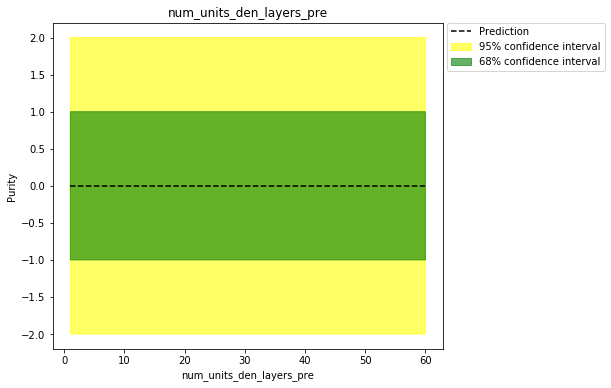

[-3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3.
 -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3.
 -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3.
 -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3.
 -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3.
 -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3.
 -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3.
 -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3.
 -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3.
 -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3.
 -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3.
 -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3.
 -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3.
 -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3

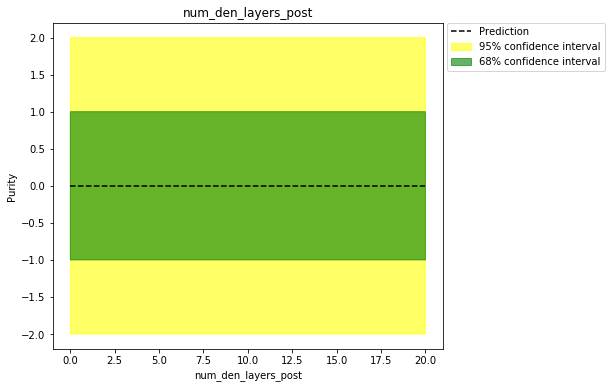

[-3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3.
 -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3.
 -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3.
 -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3.
 -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3.
 -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3.
 -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3.
 -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3.
 -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3.
 -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3.
 -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3.
 -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3.
 -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3.
 -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3

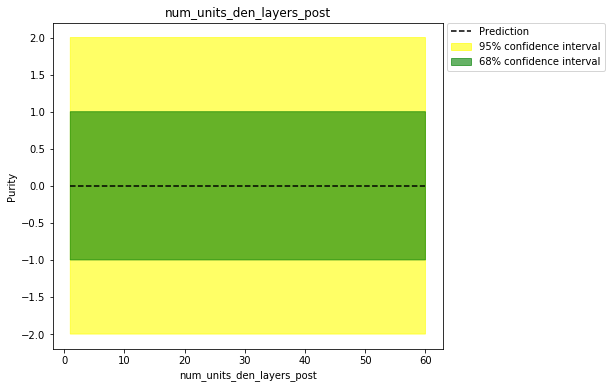

[-3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3.
 -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3.
 -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3.
 -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3.
 -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3.
 -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3.
 -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3.
 -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3.
 -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3.
 -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3.
 -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3.
 -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3.
 -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3.
 -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3

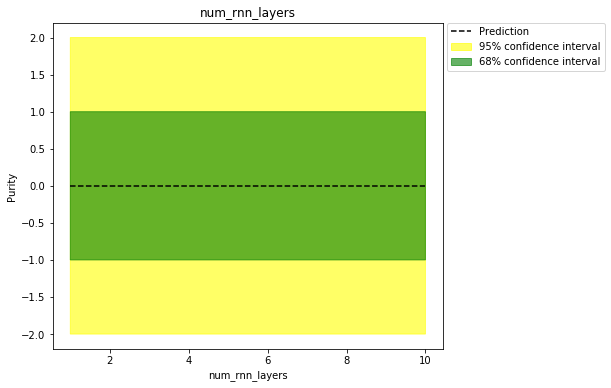

[-3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3.
 -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3.
 -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3.
 -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3.
 -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3.
 -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3.
 -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3.
 -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3.
 -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3.
 -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3.
 -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3.
 -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3.
 -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3.
 -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3

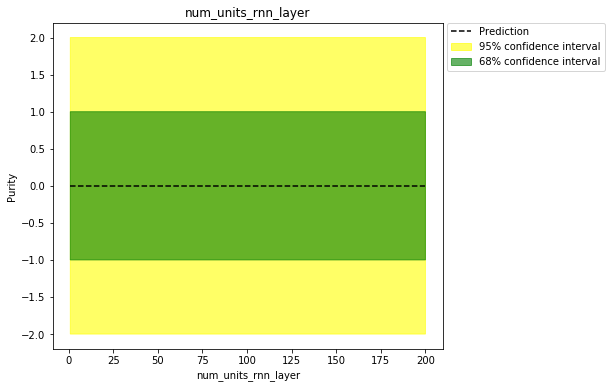

[-4.         -3.997998   -3.995996   -3.99399399 -3.99199199 -3.98998999
 -3.98798799 -3.98598599 -3.98398398 -3.98198198 -3.97997998 -3.97797798
 -3.97597598 -3.97397397 -3.97197197 -3.96996997 -3.96796797 -3.96596597
 -3.96396396 -3.96196196 -3.95995996 -3.95795796 -3.95595596 -3.95395395
 -3.95195195 -3.94994995 -3.94794795 -3.94594595 -3.94394394 -3.94194194
 -3.93993994 -3.93793794 -3.93593594 -3.93393393 -3.93193193 -3.92992993
 -3.92792793 -3.92592593 -3.92392392 -3.92192192 -3.91991992 -3.91791792
 -3.91591592 -3.91391391 -3.91191191 -3.90990991 -3.90790791 -3.90590591
 -3.9039039  -3.9019019  -3.8998999  -3.8978979  -3.8958959  -3.89389389
 -3.89189189 -3.88988989 -3.88788789 -3.88588589 -3.88388388 -3.88188188
 -3.87987988 -3.87787788 -3.87587588 -3.87387387 -3.87187187 -3.86986987
 -3.86786787 -3.86586587 -3.86386386 -3.86186186 -3.85985986 -3.85785786
 -3.85585586 -3.85385385 -3.85185185 -3.84984985 -3.84784785 -3.84584585
 -3.84384384 -3.84184184 -3.83983984 -3.83783784 -3

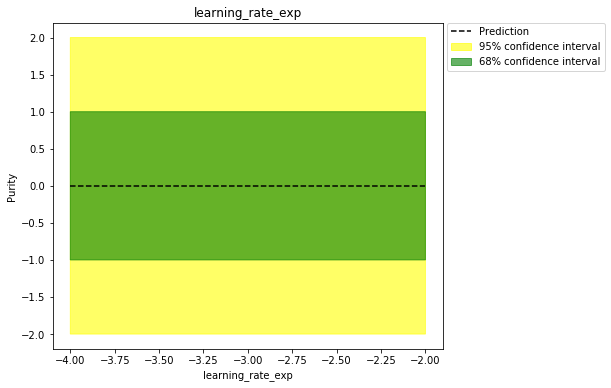

In [144]:
# for n in range(len(best_params)):
with PdfPages('opt_plots_param_number_{}.pdf'.format(n)) as pdf:
    for key,values in params_range.items():
        CreatePlots(best_params[0], key, pdf, 'n_bin', key)
        


In [100]:
for key,values in params_range.items():
    print(key)

num_den_layers_pre
num_units_den_layers_pre
num_den_layers_post
num_units_den_layers_post
num_rnn_layers
num_units_rnn_layer
learning_rate_exp


In [136]:
best_params[0]

array([-3., 10.,  0.,  5., 15., 15., 74.])